# Content Reconstruction Visualization

Author: YinTaiChen

## Packages

In [1]:
from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import os

## Cuda

In [2]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [3]:
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
print(dtype)

<class 'torch.cuda.FloatTensor'>


## Load content image

In [4]:
imsize = 512

loader = transforms.Compose([
    transforms.Scale(imsize),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    image = image.unsqueeze(0)
    return image

content_img = image_loader("Lenna.png").type(dtype)

## Display the image

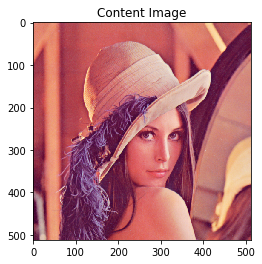

In [5]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.clone().cpu()
    image = image.view(3, imsize, imsize)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
plt.figure()
imshow(content_img.data, title="Content Image")

## Content loss

In [6]:
class ContentLoss(nn.Module):
    
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.criterion = nn.MSELoss()
        
    def forward(self, input):
        self.loss = self.criterion(input, self.target)
        self.output = input.clone()
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

## Load the neural network

In [7]:
cnn = models.vgg19(pretrained=True).features

if use_cuda:
    cnn = cnn.cuda()

In [8]:
content_layers_default = ['conv_4']

def get_model_and_losses(cnn, content_img, content_layers=content_layers_default):
    cnn = copy.deepcopy(cnn)
    
    content_losses = []
    
    model = nn.Sequential()
    
    if use_cuda:
        model = model.cuda()
    
    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)
            
            if name in content_layers:
                target = model(content_img).clone()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)
                
        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)
            
            if name in content_layers:
                target = model(content_img).clone()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)
            
            i += 1
            
        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)
            
    return model, content_losses

## Input image

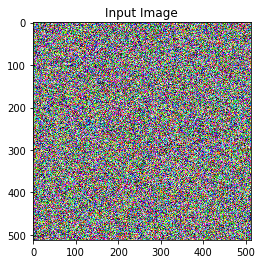

In [9]:
input_img = Variable(torch.randn(content_img.data.size())).type(dtype)

plt.figure()
imshow(input_img.data, title='Input Image')

In [10]:
print(content_img)

Variable containing:
( 0 , 0 ,.,.) = 
  0.8863  0.8863  0.8745  ...   0.9020  0.8667  0.7843
  0.8863  0.8863  0.8745  ...   0.9020  0.8667  0.7843
  0.8863  0.8863  0.8745  ...   0.9020  0.8667  0.7843
           ...             ⋱             ...          
  0.3294  0.3294  0.3608  ...   0.6784  0.6745  0.6941
  0.3216  0.3216  0.3765  ...   0.7020  0.7098  0.7255
  0.3216  0.3216  0.3765  ...   0.7020  0.7098  0.7255

( 0 , 1 ,.,.) = 
  0.5373  0.5373  0.5373  ...   0.5804  0.5098  0.3882
  0.5373  0.5373  0.5373  ...   0.5804  0.5098  0.3882
  0.5373  0.5373  0.5373  ...   0.5804  0.5098  0.3882
           ...             ⋱             ...          
  0.0706  0.0706  0.1059  ...   0.2863  0.2667  0.2431
  0.0863  0.0863  0.1255  ...   0.2745  0.2784  0.2902
  0.0863  0.0863  0.1255  ...   0.2745  0.2784  0.2902

( 0 , 2 ,.,.) = 
  0.4902  0.4902  0.5216  ...   0.4784  0.4314  0.3529
  0.4902  0.4902  0.5216  ...   0.4784  0.4314  0.3529
  0.4902  0.4902  0.5216  ...   0.4784  0.4314

In [11]:
print(input_img)

Variable containing:
( 0 , 0 ,.,.) = 
 -6.9909e-01  1.4089e+00 -3.4739e-01  ...  -6.6618e-01 -1.5476e+00 -1.3661e+00
 -9.2348e-01 -2.0502e+00 -6.1741e-01  ...  -6.9184e-01  1.2870e+00 -1.4834e+00
 -1.8500e-02 -3.5184e-01 -9.4607e-01  ...  -9.3038e-01  1.3263e+00  7.1453e-01
                 ...                   ⋱                   ...                
  5.2258e-02 -1.3120e+00 -1.4236e+00  ...   1.1193e+00  8.5167e-02 -1.5111e+00
  9.8125e-01 -6.5038e-01 -2.3989e+00  ...   2.6428e-01 -7.6924e-01  6.3838e-01
 -1.1756e+00  6.9932e-01  1.6658e-01  ...   1.0871e+00 -5.1052e-01 -1.4491e-02

( 0 , 1 ,.,.) = 
 -1.6017e-01  2.8781e+00  6.6271e-01  ...  -6.1618e-02  3.1845e-01 -6.6632e-01
 -1.4096e+00 -1.4464e+00 -2.7163e-02  ...   1.9326e+00 -7.4543e-01  9.5858e-01
 -4.1308e-02 -2.6848e-01  1.6845e+00  ...  -8.8004e-01 -1.3004e-01  3.6439e-01
                 ...                   ⋱                   ...                
  2.9294e-01 -1.4216e+00 -4.7160e-01  ...  -3.0354e-01  3.5327e-01  3.4183e

## Gradient descent

In [15]:
def get_input_param_optimizer(input_img):
    input_param = nn.Parameter(input_img.data)
    
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

In [16]:
def run_content_reconstruction(cnn, content_img, input_img, num_steps=300):
    print('Building the content reconstruction model...')
    model, content_losses = get_model_and_losses(cnn, content_img)
    input_param, optimizer = get_input_param_optimizer(input_img)
    
    print('Optimizing...')
    
    # Create folder
    if not os.path.exists('content'):
        os.makedirs('content')
    
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
            # Save modified input_img
            to_save = unloader(input_param.data.clone().cpu().view(3, 512, 512))
            to_save.save('./content/'+str(run[0])+'.jpg')
            
            input_param.data.clamp_(0, 1)
            
            optimizer.zero_grad()
            model(input_param)
            content_score = 0
            
            for cl in content_losses:
                content_score += cl.backward()
            
            run[0] += 1
            
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Content Loss: {:4f}'.format(content_score.data[0]))
                print()
                
            return content_score
        
        optimizer.step(closure)
        
    input_param.data.clamp_(0, 1)
    
    return input_param.data

In [17]:
output = run_content_reconstruction(cnn, content_img, input_img)

Building the content reconstruction model...
Optimizing...
run [50]:
Content Loss: 0.116906

run [100]:
Content Loss: 0.041165

run [150]:
Content Loss: 0.015947

run [200]:
Content Loss: 0.006323

run [250]:
Content Loss: 0.047128

run [300]:
Content Loss: 0.005138



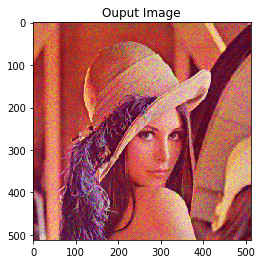

In [18]:
plt.figure()
imshow(output, title='Ouput Image')

plt.ioff()
plt.show()

## Generate GIF

In [20]:
import imageio

In [24]:
images = []
for i in range(321):
    filename = "./content/"+str(i)+".jpg"
    if i <= 50:
        images.append(imageio.imread(filename))
    elif i % 10 == 0:
        images.append(imageio.imread(filename))
imageio.mimsave('content_reconstruction.gif', images)